In [181]:
# 모듈 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import time
import os

In [182]:
# 데이터 불러오기
column_names = ['timestamp', 'v_raw', 'c_raw', 'voltage', 'current', 'label']
df_normal = pd.read_excel('../sample_dataset/preprocessed/50ohm_정상_train.xlsx')
df_arc = pd.read_excel('../sample_dataset/preprocessed/50ohm_아크_train.xlsx')
test_df = pd.read_excel('../sample_dataset/preprocessed/50ohm_통합_test.xlsx')

column_names = ['timestamp', 'v_raw', 'c_raw', 'power_voltage', 'power_current', 'label']
test_df = pd.read_csv('../realtime/test/arc_10sec_RLC_1.csv', names=column_names, header=None)

# 컬럼명 통일
df_normal = df_normal.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})
df_arc = df_arc.rename(columns={'arc_voltage': 'voltage', 'arc_current': 'current'})
test_df = test_df.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})

# 라벨 추가
df_normal['label'] = 0
df_arc['label'] = 1

train_df = pd.concat([df_normal, df_arc], ignore_index=True)

In [183]:
# 파생 피처 생성 함수
def add_features(voltage_seq, current_seq):
    voltage = np.mean(voltage_seq)
    current = np.mean(current_seq)
    voltage_diff = np.abs(voltage_seq[-1] - voltage_seq[-2])
    current_diff = np.abs(current_seq[-1] - current_seq[-2])
    voltage_ma = np.mean(voltage_seq[-5:])
    current_ma = np.mean(current_seq[-5:])
    power = voltage * current
    power_diff = np.abs(power - (voltage_seq[-2] * current_seq[-2]))
    return [voltage, current, voltage_diff, current_diff, voltage_ma, current_ma, power, power_diff]

In [184]:
# 슬라이딩 윈도우로 피처 생성
def generate_sequence_features(df, window_size=8):
    features = []
    labels = []

    for i in range(window_size, len(df)):
        voltage_seq = df['voltage'].iloc[i - window_size:i].values
        current_seq = df['current'].iloc[i - window_size:i].values
        feat = add_features(voltage_seq, current_seq)
        features.append(feat)
        labels.append(df['label'].iloc[i])  # 마지막 인덱스의 라벨 사용

    return np.array(features), np.array(labels)

In [185]:
# 피처 및 라벨 설정
print(train_df.shape)
X_train, y_train = generate_sequence_features(train_df)
X_test, y_test = generate_sequence_features(test_df)
print(X_train.shape)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1477, 98)
(1469, 8)


In [186]:
# 모델 및 스케일러 로드
model = joblib.load('./model/one_class_svm_model.joblib')  # ← 변경된 모델 파일
scaler = joblib.load('./model/scaler.joblib')


In [187]:
# 예측 및 평가
y_pred = model.predict(X_test_scaled)
y_pred_bin = (y_pred == -1).astype(int)

In [188]:
def postprocess_anomalies(y_pred_bin, min_consecutive=8):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

y_pred_post = postprocess_anomalies(y_pred_bin, min_consecutive=2)
y_true_post = postprocess_anomalies(y_test, min_consecutive=2)

In [189]:
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_true_post, y_pred_post, target_names=['정상', '아크']))

📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.00      0.00      0.00         0
          아크       1.00      0.98      0.99       492

    accuracy                           0.98       492
   macro avg       0.50      0.49      0.50       492
weighted avg       1.00      0.98      0.99       492



c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [190]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

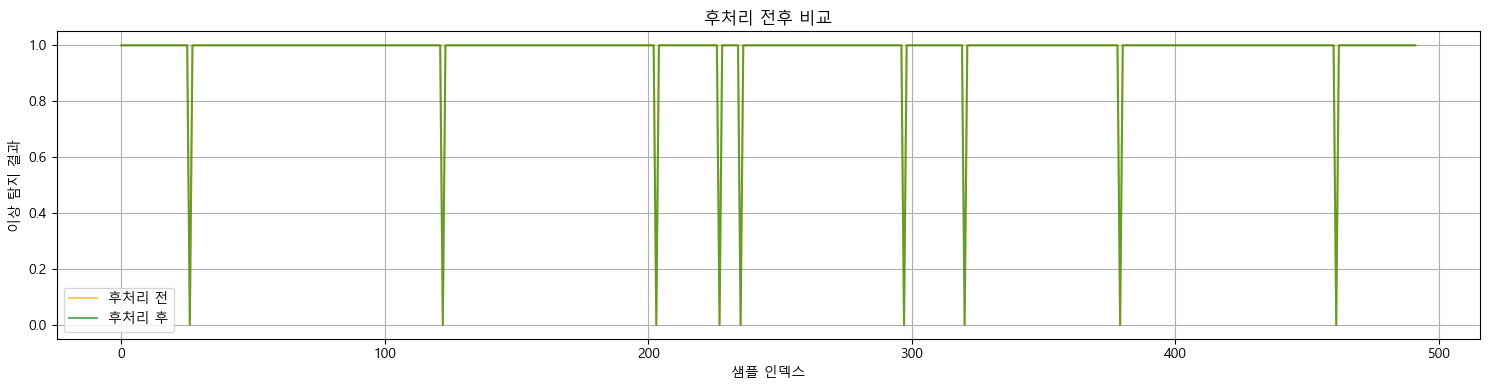

In [191]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred_bin, y_pred_post)

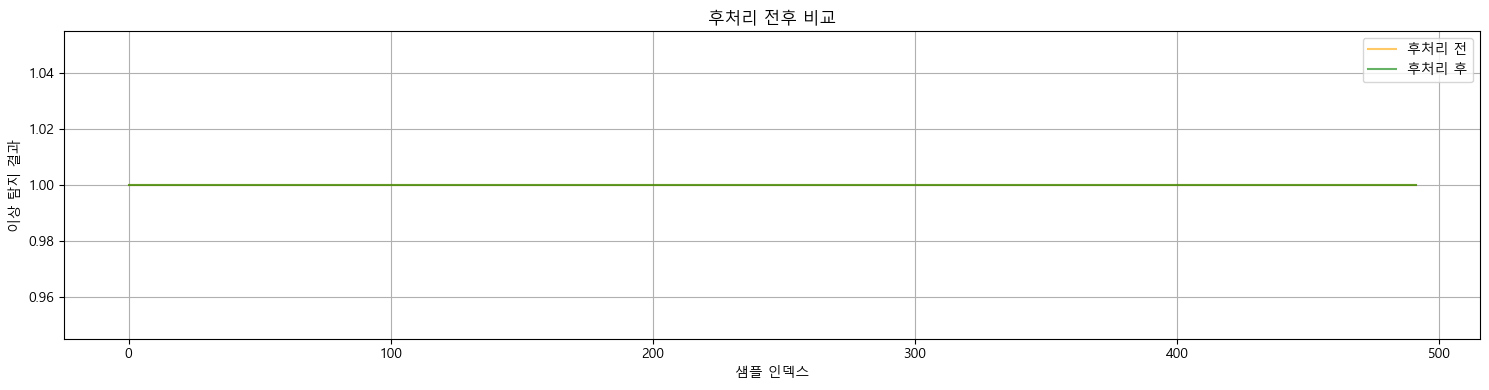

In [192]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_test, y_true_post)